[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-4/parallelization.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239934-lesson-1-parallelization)

# Parallel node execution

## Review

module-3 では、`human-in-the-loop` について詳しく説明し、3つの一般的なユースケースを示しました。

(1) `承認(Approval)` - エージェントを中断し、状態をユーザーに表示し、ユーザーがアクションを承認できるようにします

(2) `デバッグ(Debugging)`  - グラフを巻き戻して問題を再現したり回避したりすることができます

(3) `編集(Editing)` - 状態を変更することができます。

## Goals

このモジュールでは、module-2で説明した `human-in-the-loop` および `記憶(memory)`の概念を基に構築します。

`マルチエージェント` のワークフローに深く踏み込み、このコースのすべてのモジュールを統合したマルチエージェントの研究アシスタントを構築します。

このマルチエージェント研究アシスタントを構築するために、まずLangGraphの制御可能性に関するいくつかのトピックについて説明します。

まず[並列化(parallelization)](https://langchain-ai.github.io/langgraph/how-tos/branching/#how-to-create-branches-for-parallel-node-execution)から始めます。

## Fan out and fan in

各ステップで状態を上書きするシンプルな線形グラフを作成してみましょう。


In [ ]:
%%capture --no-stderr
%pip install -U  langgraph tavily-python wikipedia langchain_openai langchain_community langgraph_sdk

In [1]:
import os
import getpass


def _set_env(var: str) -> None:
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")

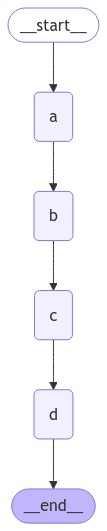

In [3]:
from IPython.display import Image, display

from typing import Any
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END


class State(TypedDict):
    # The operator.add reducer fn makes this append-only
    state: str


class ReturnNodeValue:
    def __init__(self, node_secret: str) -> None:
        self._value = node_secret

    def __call__(self, state: State) -> Any:
        print(f"Adding {self._value} to {state['state']}")
        return {"state": [self._value]}


# Add nodes
builder = StateGraph(State)

# Initialize each node with node_secret
builder.add_node("a", ReturnNodeValue(node_secret="I'm A"))
builder.add_node("b", ReturnNodeValue(node_secret="I'm B"))
builder.add_node("c", ReturnNodeValue(node_secret="I'm C"))
builder.add_node("d", ReturnNodeValue(node_secret="I'm D"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("b", "c")
builder.add_edge("c", "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

予想通り、私たちは状態を上書きします。


In [4]:
graph.invoke({"state": []})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm B"]
Adding I'm D to ["I'm C"]


{'state': ["I'm D"]}

では、`b` と `c` を並列で実行してみましょう。

そして、`d` を実行します。

これは、`a` から `b` と `c` へのfan-out、そして `d` へのfan-inで簡単に実行できます。

状態の更新は各ステップの最後に適用されます。

実行してみましょう。



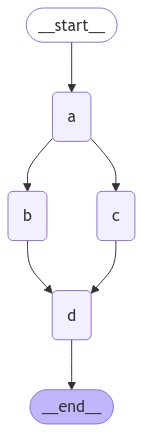

In [5]:
builder = StateGraph(State)

# Initialize each node with node_secret
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "d")
builder.add_edge("c", "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

**エラーが発生しました**!

これは、`b` と `c` が同じステップで同じstate key / channel に書き込みを行っているためです。


In [6]:
from langgraph.errors import InvalidUpdateError

try:
    graph.invoke({"state": []})
except InvalidUpdateError as e:
    print(f"An error occurred: {e}")

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
An error occurred: At key 'state': Can receive only one value per step. Use an Annotated key to handle multiple values.


fan-outを使用する際には、ステップが同じチャネル/キーに書き込んでいるならば、reducerを使用していることを確認する必要があります。

module-2で触れたように、`operator.add` はPythonのbuilt-inのoperatorモジュール由来の関数です。

`operator.add` をリストに適用すると、リストの結合を行います。



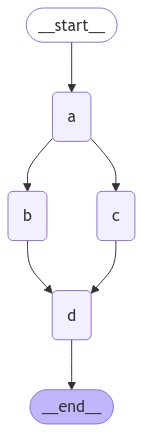

In [7]:
import operator
from typing import Annotated


class State(TypedDict):
    # The operator.add reducer fn makes this append-only
    state: Annotated[list, operator.add]


# Add nodes
builder = StateGraph(State)

# Initialize each node with node_secret
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "d")
builder.add_edge("c", "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [8]:
graph.invoke({"state": []})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm D to ["I'm A", "I'm B", "I'm C"]


{'state': ["I'm A", "I'm B", "I'm C", "I'm D"]}

今、`b` と `c` によって並列に行われた更新を状態に追加していることがわかります。



## Waiting for nodes to finish

Now, lets consider a case where one parallel path has more steps than the other one.

## ノードが終了するのを待つ

では、一方の並列処理がもう一方よりもステップ数が多い場合について考えてみましょう。




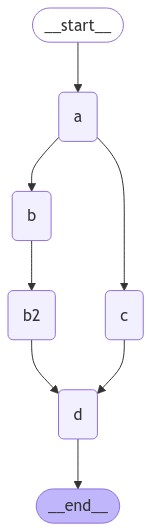

In [9]:
builder = StateGraph(State)

# Initialize each node with node_secret
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("b2", ReturnNodeValue("I'm B2"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "b2")
builder.add_edge(["b2", "c"], "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

この場合、`b`、`b2`、および`c`はすべて同じステップです。

グラフは、ステップ`d`に進む前に、これらすべてが完了するのを待ちます。


In [10]:
graph.invoke({"state": []})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm B2 to ["I'm A", "I'm B", "I'm C"]
Adding I'm D to ["I'm A", "I'm B", "I'm C", "I'm B2"]


{'state': ["I'm A", "I'm B", "I'm C", "I'm B2", "I'm D"]}

## state更新の順序を設定する

しかし、各ステップ内では、ステート更新の順序を特定の方法で制御することはできません。

簡単に言えば、これはLangGraphがグラフトポロジーに基づいて決定する決定論的な順序であり、**私たちは制御できません**。

上図では、`c`が`b2`の前に追加されていることが分かります。

しかし、カスタムreducerを使用して、例えばstate更新をソートするなど、この順序をカスタマイズすることができます。




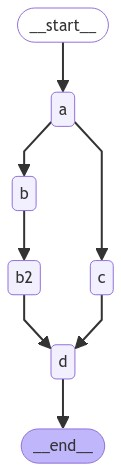

In [9]:
def sorting_reducer(left, right) -> list:
    """Combines and sorts the values in a list"""
    if not isinstance(left, list):
        left = [left]

    if not isinstance(right, list):
        right = [right]

    return sorted(left + right, reverse=False)


class State(TypedDict):
    # sorting_reducer will sort the values in state
    state: Annotated[list, sorting_reducer]


# Add nodes
builder = StateGraph(State)

# Initialize each node with node_secret
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("b2", ReturnNodeValue("I'm B2"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "b2")
builder.add_edge(["b2", "c"], "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [10]:
graph.invoke({"state": []})

Adding I'm A to []
Adding I'm C to ["I'm A"]
Adding I'm B to ["I'm A"]
Adding I'm B2 to ["I'm A", "I'm B", "I'm C"]
Adding I'm D to ["I'm A", "I'm B", "I'm B2", "I'm C"]


{'state': ["I'm A", "I'm B", "I'm B2", "I'm C", "I'm D"]}

reducerが更新されたstateの値をソートしています! 実装は上記のsorting_reducer()を参照して下さい。

## LLMとの連携

それでは、現実的な例を追加してみましょう!

2つの外部ソース(WikipediaとWeb検索)から文脈を収集し、LLMに質問に答えてもらいます。



In [11]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o", temperature=0)

In [12]:
class State(TypedDict):
    question: str
    answer: str
    context: Annotated[list, operator.add]

You can try different web search tools. [Tavily](https://tavily.com/) is one nice option to consider, but ensure your `TAVILY_API_KEY` is set.

In [13]:
def _set_env(var: str) -> None:
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("TAVILY_API_KEY")

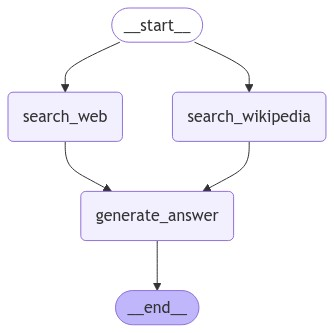

In [14]:
from langchain_core.messages import HumanMessage, SystemMessage

from langchain_community.document_loaders import WikipediaLoader
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages.base import BaseMessage


def search_web(state) -> dict[str, list[str]]:
    """Retrieve docs from web search"""

    # Search
    tavily_search = TavilySearchResults(max_results=3)
    search_docs = tavily_search.invoke(state["question"])

    # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>' for doc in search_docs]
    )

    return {"context": [formatted_search_docs]}


def search_wikipedia(state) -> dict[str, list[str]]:
    """Retrieve docs from wikipedia"""

    # Search
    search_docs = WikipediaLoader(query=state["question"], load_max_docs=2).load()

    # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}


def generate_answer(state) -> dict[str, BaseMessage]:
    """Node to answer a question"""

    # Get state
    context = state["context"]
    question = state["question"]

    # Template
    answer_template = """Answer the question {question} using this context: {context}"""
    answer_instructions = answer_template.format(question=question, context=context)

    # Answer
    answer = llm.invoke([SystemMessage(content=answer_instructions)] + [HumanMessage(content=f"Answer the question.")])

    # Append it to state
    return {"answer": answer}


# Add nodes
builder = StateGraph(State)

# Initialize each node with node_secret
builder.add_node("search_web", search_web)
builder.add_node("search_wikipedia", search_wikipedia)
builder.add_node("generate_answer", generate_answer)

# Flow
builder.add_edge(START, "search_wikipedia")
builder.add_edge(START, "search_web")
builder.add_edge("search_wikipedia", "generate_answer")
builder.add_edge("search_web", "generate_answer")
builder.add_edge("generate_answer", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
result = graph.invoke({"question": "How were Nvidia's Q2 2024 earnings"})
result["answer"].content

"Nvidia's Q2 2024 earnings exceeded expectations. The company reported earnings of $2.70 per share, adjusted, compared to the $2.09 per share expected by Refinitiv. Additionally, Nvidia's revenue for the quarter was $13.51 billion, surpassing the expected $11.22 billion."

## Using with LangGraph API

--

**⚠️ 免責事項**

*Studio を実行するには現在 Mac が必要です。Mac を使用していない場合は、この手順をスキップしてください。*

*また、このノートブックを CoLab で実行している場合は、この手順をスキップしてください。*

--

上記のグラフをStudio UIに読み込みましょう。これは、`module-4/studio/langgraph.json`で設定された`module-4/studio/parallelization.py`を使用します。

![Screenshot 2024-08-29 at 3.05.13 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb10f43c3d4df239e0278_parallelization-1.png)

StudioからローカルデプロイメントのURLを取得しましょう。



In [ ]:
import platform

if "google.colab" in str(get_ipython()) or platform.system() != "Darwin":
    raise Exception("Unfortunately LangGraph Studio is currently not supported on Google Colab or requires a Mac")

In [17]:
from langgraph_sdk import get_client

client = get_client(url="http://localhost:63082")

In [18]:
thread = await client.threads.create()
input_question = {"question": "How were Nvidia Q2 2024 earnings?"}
async for event in client.runs.stream(
    thread["thread_id"], assistant_id="parallelization", input=input_question, stream_mode="values"
):
    # Check if answer has been added to state
    answer = event.data.get("answer", None)
    if answer:
        print(answer["content"])

Nvidia's Q2 2024 earnings were exceptionally strong. The company reported $13.5 billion in revenue, significantly surpassing expectations, and made $6 billion in pure profit. The earnings per share were $2.70, adjusted, compared to the $2.09 per share expected by analysts. The gross profit margins were 75.1%, and the adjusted earnings per share were 68 cents. The strong performance was driven by unprecedented demand for its generative AI chips.
